## Nonparametric Demand Estimation with Julia
This notebook provides an example of nonparametric demand estimation using the NPDemand.jl package, written by me (James Brand). I run through an example in which we have data on 2J products, but each product is only a substitute for J products. That is, for J=2, consumers substitute between products 1 and 2, and between 3 and 4, but never between any other two products. I run a model selection procedure to determine which products are close substitutes and then apply the nonparametric demand estimation procedure from Compiani (2020). 

In [2]:
# ] add https://github.com/jamesbrandecon/NPDemand.jl
using Statistics, RCall, DataFrames
using NPDemand
@rlibrary ggplot2

### Initializing
We need to define the number of products per market, the number of markets, and some utility parameters. Then we set up the number of simulation runs and the grid on which we want to compute price elasticites. 

In [3]:
J=2; # number of products
T =1000;
beta = -0.4; # price coefficient in utility function
sdxi = 0.15; # standard deviation of xi

S = 50; # number of simulations
G = 10; # size of grid on which to evaluate price elasticities
esep_own = zeros(S,G);
esep_cross = zeros(S,G);
esep_own_dist = zeros(S,T);
esepTrue = zeros(S,G);

s, pt, zt, xi = NPDemand.simulate_logit(J,T, beta, sdxi);
p_points = range(quantile(pt[:,1],.25),stop = quantile(pt[:,1],.75),length = G);
p_points = convert.(Float64, p_points);

### Set options for estimation and elasticity calculation

In [4]:
bernO = 3*ones(2J,1);       # Order of Bernstein Polynomial
iv=0;                       # Order of IV Polynomial = (bernO + iv)
constrained = 0;            # Monotonicity Constraint (experience says you always want this on)
xt = zeros(T,2J);           # No exogenous product characteristics
trueS = 0;                  # Evaluate at true market shares or not
own = [1,1];                # [derivative of j, with respect to price of k]
cross = [1,2];
nfolds = 5; # number of cross-validation folds
nlam = 10; # number of regularization parameters to try. Actual values chosen automatically by hierNet
strong = true; # boolean for whether or not to impose strong hierarchy constraint
# Note: "strong = true" takes much longer than "strong = false."
nboot = 5;

### Run simulations
Each iteration of this loop does four things: 
- Simulate demand, prices, and instruments (because prices are correlated with unobservable demand shifters)
- Select the relevant substitutes for each product (each only substitutes to J-1 others) 
- Estimate demand for each product nonparametrically
- Calculate own-price elasticities for product 1 (controlled by the matrix "own" above)

In [ ]:
included_symmetric_pct = zeros(2J,2J)
included_pct = zeros(2J,2J)
for si = 1:1:S
    # Simulate demand in two groups -- each product only substitutes to J-1 others
    s, pt, zt = NPDemand.simulate_logit(J,T, beta, sdxi);
    s2, pt2, zt2  = NPDemand.simulate_logit(J,T, beta, sdxi);

    s = [s s2];
    s = s ./ 2;
    pt = [pt pt2];
    zt = [zt zt2];

    # hierNet() Returns two matrices: one, the "raw" selected model, and another
    #   which imposes symmetry. I.e. if j is a substute for k, then k is
    #   a substitute for j as well (this can drastically increase the # parameters
    #    to estimate when s has many columns)
    included, included_symmetric = NPDemand.hierNet_boot(s, pt, zt, nfolds, nlam, false, nboot);

    # Estimate demand nonparametrically
        # If you want to include an additional covariate in all demand
        # functions, add an additional argument "marketvars" after included. If it is an
        # additional product characteristic, marketvars should be T x J
    inv_sigma, designs = NPDemand.inverse_demand(s, pt, xt, zt, bernO, iv, 2J, constrained, included_symmetric, nothing);

    # Calculate price elasticities
    deltas = -1*median(pt).*ones(G,2J);
    deltas[:,1] = -1*p_points;
    esep, Jacobians, share_vec = NPDemand.price_elasticity_priceIndex(inv_sigma, s, p_points, deltas, bernO, own, included_symmetric, trueS,[]);
    trueEsep = beta.*p_points.*(1 .- 2*share_vec[:,1])
    
    esep_own[si,:] = esep;
    esepTrue[si,:] = trueEsep;
    included_pct[:,:] += included./S; # summarizing selection patterns. See pure_model_selection.jl
    included_symmetric_pct[:,:] += included_symmetric./S;
end
# (output of model selection R code suppressed)

### Plotting results
Now we'll use the extremely convenient `@rlibrary ggplot2` command we ran above to call ggplot directly. Plot shows the true price elasticty as well as the 90th and 10th percentiles (across simulations) of estimated own-price elasticities for product 1 at each point in the grid.

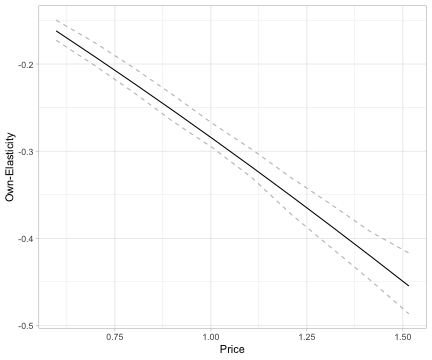

RObject{VecSxp}


In [6]:
esep_l = zeros(G,1)
esep50 = zeros(G,1)
esep_h = zeros(G,1)
for i = 1:G
    esep_l[i] = quantile(esep_own[:,i], 0.1)
    esep50[i] = quantile(esep_own[:,i], 0.5)
    esep_h[i] = quantile(esep_own[:,i], 0.9)
end
esep_l = dropdims(esep_l,dims = 2);
esep50 = dropdims(esep50,dims = 2);
esep_h = dropdims(esep_h,dims = 2);

df = DataFrame(p = p_points, e_l = esep_l, e_true = esepTrue[1,:], e_h = esep_h)
ggplot(df, aes(x=:p, y=:e_true)) + geom_line() + geom_line(aes(y=:e_h), color = "gray", linetype = "dashed") +
    geom_line(aes(y=:e_l), color = "gray", linetype = "dashed") +
    xlab("Price") + ylab("Own-Elasticity") + theme_light()

Just as we hoped, the estimates surround the truth fairly closely. Note: if we wanted cross-price elasticities, we could replace the matrix `own` with `cross`, or in situations with more asymmetries (or more products) any other combination of two product indices. 